In [1]:
library("devtools")
library("tidyverse")
library("EnhancedVolcano")

Loading required package: usethis

-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.2          v readr     2.1.4     
v forcats   1.0.0.9000     v stringr   1.5.0     
v ggplot2   3.4.3          v tibble    3.2.1     
v lubridate 1.9.2          v tidyr     1.3.0     
v purrr     1.0.1          
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: ggrepel



In [2]:
all_acrs <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/03.peak_assignment/uf_dir/uf_acr_classification.no_exons.all_ACRs.classified.sorted.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")

bundle_sheath_control_ACRs_cell_type <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/uf_dir/control_bed/uf.bundle_sheath.broad_acr_null_list.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    
fimo_output_tsv <- read_tsv("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/uf_dir/all_acrs/uf_fimo_output/fimo.tsv")

mesophyll_control_ACRs_cell_type <- read_delim("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/06.motif_enrichment/uf_dir/control_bed/uf.mesophyll.broad_acr_null_list.bed", delim = "\t", col_names = c("chr", "start", "stop", "acr_name", "score")) %>% 
    separate(acr_name, into = c("ACR_number", "ACR_Class"), sep = ";")
    

Rows: 29153 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (3): chr, acr_name, score
dbl (2): start, stop

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 3266 Columns: 5
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (2): chr, acr_name
dbl (2): start, stop
lgl (1): score

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 5240619 Columns: 10
-- Column specification --------------------------------------------------------
Delimiter: "\t"
chr (5): motif_id, motif_alt_id, sequence_name, strand, matched_sequence
dbl (5

In [3]:
    number_cell_type_acrs <- all_acrs %>% 
    dplyr::group_by(ACR_Class) %>% 
    summarise(acr_per_ct = n())

In [4]:
fimo_output_tsv <- fimo_output_tsv #%>% 
 #   separate(sequence_name, into = c("ACR_number", "acr_type_location"), sep = ";") %>% 
 #   separate(acr_type_location, into = c("ACR_Class", "location"), sep = "::")



In [5]:
fimo_output <- fimo_output_tsv %>% 
    separate(sequence_name, into = c("ACR_number", "acr_type_location"), sep = ";") %>% 
    separate(acr_type_location, into = c("ACR_Class", "location"), sep = "::")



In [6]:
cell_type_sepcific_acrs_contigency <- fimo_output %>% 
    dplyr::filter(ACR_Class != "broadly_accessible") %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(counts = n())

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.


In [7]:
bundle_sheath_control_acrs <- fimo_output %>% 
    dplyr::filter(ACR_number %in% bundle_sheath_control_ACRs_cell_type$ACR_number) %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(control_counts = n()) %>% 
    mutate(control_class = "bundle_sheath") %>% 
    select(-ACR_Class) %>% 
    select(motif_id, control_class, control_counts)

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.
Adding missing grouping variables: `motif_alt_id`


In [8]:
cell_type_sepcific_acrs_contigency_joined <- left_join(cell_type_sepcific_acrs_contigency, number_cell_type_acrs, by = c("ACR_Class"))

In [9]:
cell_type_sepcific_acrs_contigency_w_log2 <- cell_type_sepcific_acrs_contigency_joined %>% 
    dplyr::mutate(fraction_cts_acrs_w_motif = counts/acr_per_ct) %>% 
    filter(!str_detect(ACR_Class, ",")) %>% 
    left_join(., bundle_sheath_control_acrs, by = c("motif_id","ACR_Class" = "control_class")) %>% 
    dplyr::filter(ACR_Class == "bundle_sheath") %>% 
    dplyr::mutate(fraction_control_w_motif = control_counts/acr_per_ct) %>% 
    rowwise() %>% 
    mutate(log2FoldChange = log2(fraction_cts_acrs_w_motif/fraction_control_w_motif),
            test_stat = chisq.test(c(counts, control_counts))$statistic,
            p_val = chisq.test(c(counts, control_counts))$p.value) %>% 
    ungroup() %>% 
    mutate(adjusted_pval = p.adjust(p_val, method="fdr")) %>% 
  group_by(motif_alt_id.x ) %>%
  mutate(row_num = case_when(n() > 1 ~ as.character(row_number()), TRUE ~ "")) %>%
  ungroup() %>%
  mutate(motif_alt_id = paste0(motif_alt_id.x ,".", row_num)) %>%
  select(-row_num)

    

In [10]:
head(cell_type_sepcific_acrs_contigency_w_log2)

motif_id,motif_alt_id.x,ACR_Class,counts,acr_per_ct,fraction_cts_acrs_w_motif,motif_alt_id.y,control_counts,fraction_control_w_motif,log2FoldChange,test_stat,p_val,adjusted_pval,motif_alt_id
<chr>,<chr>,<chr>,<int>,<int>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
MA0001.2,AGL3,bundle_sheath,236,3266,0.07225964,AGL3,185,0.05664421,0.3512616,6.1781473,0.01293376,0.02598728,AGL3.
MA0005.2,AG,bundle_sheath,178,3266,0.05450092,AG,164,0.05021433,0.1181814,0.5730994,0.44902991,0.53342787,AG.
MA0008.3,HAT5,bundle_sheath,283,3266,0.08665034,HAT5,250,0.07654623,0.1788740,2.0431520,0.15289255,0.21830908,HAT5.
MA0034.1,Gam1,bundle_sheath,398,3266,0.12186160,Gam1,474,0.14513166,-0.2521186,6.6238532,0.01006219,0.02066399,Gam1.
MA0054.1,myb.Ph3,bundle_sheath,119,3266,0.03643601,myb.Ph3,119,0.03643601,0.0000000,0.0000000,1.00000000,1.00000000,myb.Ph3.
MA0082.1,squamosa,bundle_sheath,393,3266,0.12033068,squamosa,332,0.10165340,0.2433461,5.1324138,0.02348305,0.04380362,squamosa.


In [11]:
calculate_chi_square <- cell_type_sepcific_acrs_contigency_w_log2

In [12]:
calculate_chi_square_subset <- calculate_chi_square %>% 
    select(motif_alt_id, log2FoldChange, adjusted_pval)


calculate_chi_square_subset.df <- as.data.frame(calculate_chi_square_subset)
row.names(calculate_chi_square_subset.df) <- calculate_chi_square_subset.df$motif_alt_id
res <- calculate_chi_square_subset.df[,2:3]

In [13]:
arrange(calculate_chi_square_subset, by = adjusted_pval)

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
ERF8.,-1.0362087,0.000000e+00
ERF003.,-1.0988573,0.000000e+00
LEP.,-1.0357309,0.000000e+00
ERF9.,-1.0092043,0.000000e+00
Zm00001d020267.,-1.0074978,0.000000e+00
Zm00001d005892.,-1.0274232,0.000000e+00
Zm00001d024324.,-1.0028367,0.000000e+00
Zm00001d049364.,-1.1638813,0.000000e+00
ERF115.,-1.0752340,0.000000e+00


Warning message:
"One or more p-values is 0. Converting to 10^-1 * current lowest non-zero p-value..."
Warning message:
"ggrepel: 114 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


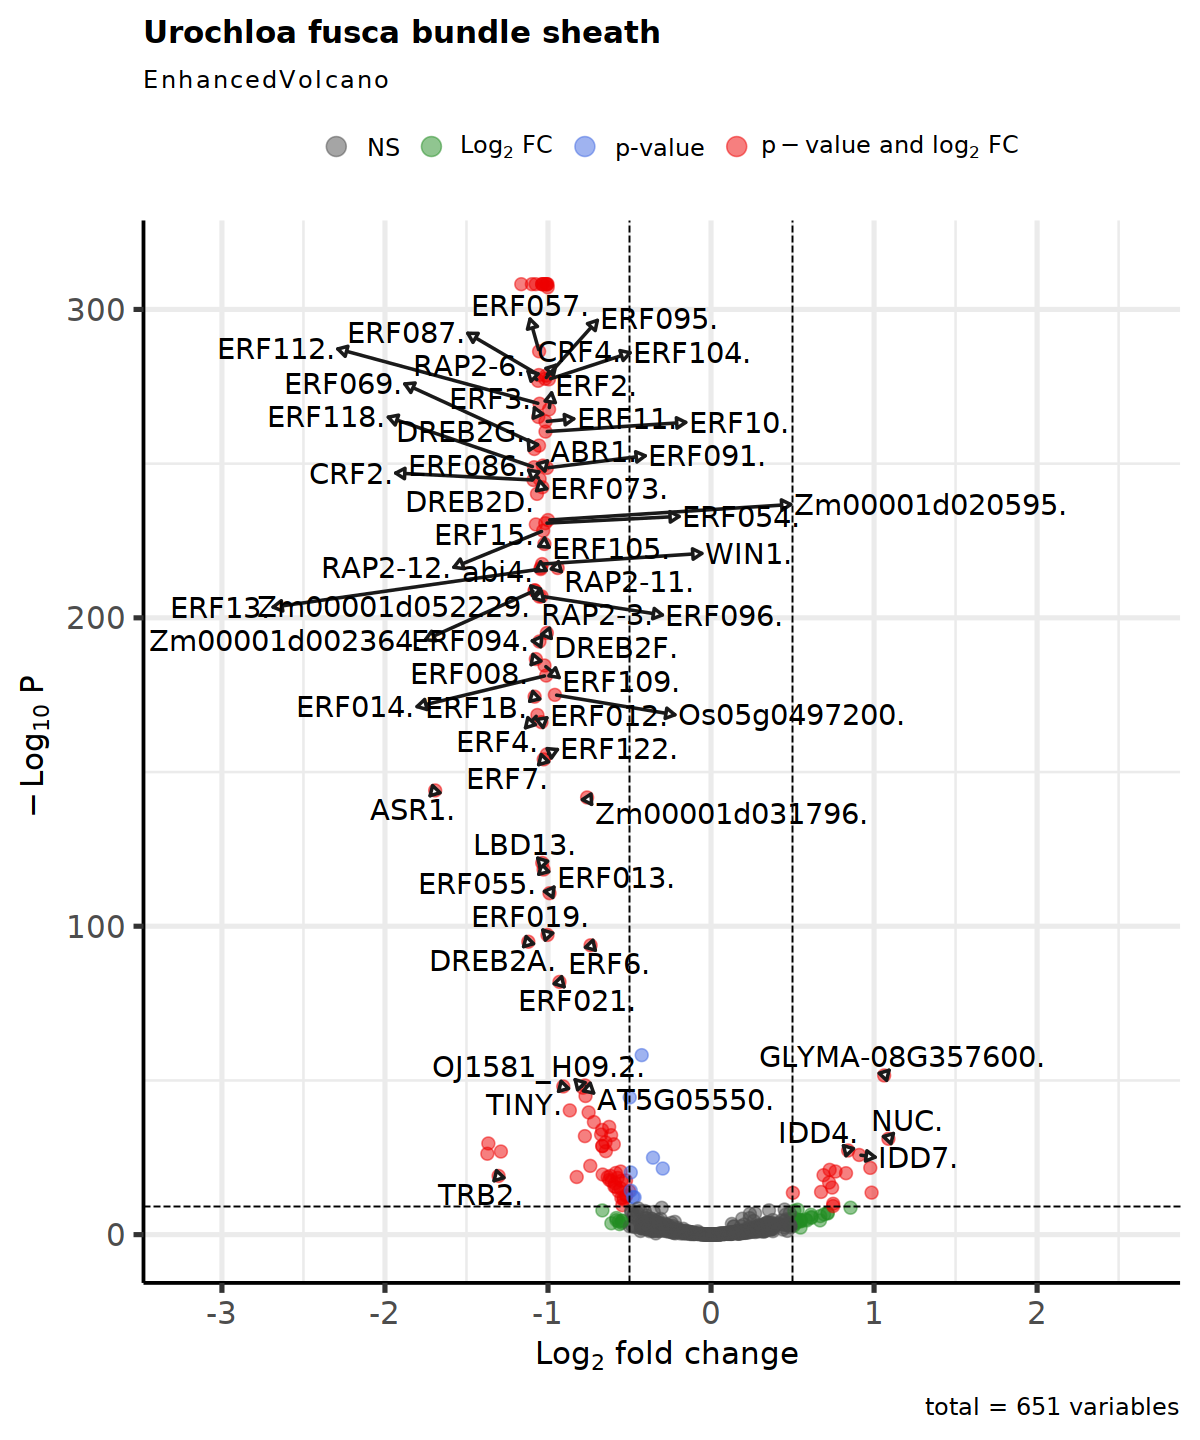

In [26]:
options(repr.plot.width=10, repr.plot.height=12)

EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'adjusted_pval',
    title = 'Urochloa fusca bundle sheath',
    pCutoff = 10e-10,
    FCcutoff = 0.5,
    pointSize = 3.0,
    labSize = 6.0, 
    drawConnectors = TRUE,
    widthConnectors = 0.75)

# Mesophyll Try

In [15]:
    

mesophyll_control_acrs <- fimo_output %>% 
    dplyr::filter(ACR_number %in% mesophyll_control_ACRs_cell_type$ACR_number) %>% 
    group_by(motif_id, motif_alt_id, ACR_Class) %>% 
    summarise(control_counts = n()) %>% 
    mutate(control_class = "mesophyll") %>% 
    select(-ACR_Class) %>% 
    select(motif_id, control_class, control_counts)

`summarise()` has grouped output by 'motif_id', 'motif_alt_id'. You can
override using the `.groups` argument.
Adding missing grouping variables: `motif_alt_id`


In [16]:
cell_type_sepcific_acrs_contigency_meso <- left_join(cell_type_sepcific_acrs_contigency, number_cell_type_acrs, by = c("ACR_Class"))

In [17]:
cell_type_sepcific_acrs_contigency_w_log2_meso <- cell_type_sepcific_acrs_contigency_meso %>% 
    dplyr::mutate(fraction_cts_acrs_w_motif = counts/acr_per_ct) %>% 
    filter(!str_detect(ACR_Class, ",")) %>% 
    left_join(., mesophyll_control_acrs, by = c("motif_id","ACR_Class" = "control_class")) %>% 
    dplyr::filter(ACR_Class == "mesophyll") %>% 
    dplyr::mutate(fraction_control_w_motif = control_counts/acr_per_ct) %>% 
    rowwise() %>% 
    mutate(log2FoldChange = log2(fraction_cts_acrs_w_motif/fraction_control_w_motif),
            test_stat = chisq.test(c(counts, control_counts))$statistic,
            p_val = chisq.test(c(counts, control_counts))$p.value) %>% 
    ungroup() %>% 
    mutate(adjusted_pval = p.adjust(p_val, method="fdr")) %>% 
  group_by(motif_alt_id.x ) %>%
  mutate(row_num = case_when(n() > 1 ~ as.character(row_number()), TRUE ~ "")) %>%
  ungroup() %>%
  mutate(motif_alt_id = paste0(motif_alt_id.x ,".", row_num)) %>%
  select(-row_num)

    

In [18]:
calculate_chi_square_subset_meso <- cell_type_sepcific_acrs_contigency_w_log2_meso %>% 
    select(motif_alt_id, log2FoldChange, adjusted_pval)


calculate_chi_square_subset_meso.df <- as.data.frame(calculate_chi_square_subset_meso)
row.names(calculate_chi_square_subset_meso.df) <- calculate_chi_square_subset_meso.df$motif_alt_id
res_meso <- calculate_chi_square_subset_meso.df[,2:3]

In [19]:
res_meso

,log2FoldChange,adjusted_pval
,<dbl>,<dbl>
AGL3.,0.02487467,9.327871e-01
AG.,-0.90836952,1.168539e-04
HAT5.,-0.16349873,4.485127e-01
Gam1.,0.24972005,8.474188e-02
myb.Ph3.,0.00000000,1.000000e+00
squamosa.,-0.29260752,9.810261e-02
bZIP910.,0.09761080,7.389662e-01
bZIP911.,0.22826899,6.385254e-02
ATHB-5.,0.35466488,8.428745e-02


In [20]:
arrange(calculate_chi_square_subset, by = adjusted_pval)

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
ERF8.,-1.0362087,0.000000e+00
ERF003.,-1.0988573,0.000000e+00
LEP.,-1.0357309,0.000000e+00
ERF9.,-1.0092043,0.000000e+00
Zm00001d020267.,-1.0074978,0.000000e+00
Zm00001d005892.,-1.0274232,0.000000e+00
Zm00001d024324.,-1.0028367,0.000000e+00
Zm00001d049364.,-1.1638813,0.000000e+00
ERF115.,-1.0752340,0.000000e+00


In [21]:
calculate_chi_square_subset %>% 
    filter(str_detect(motif_alt_id, "DOF"))

motif_alt_id,log2FoldChange,adjusted_pval
<chr>,<dbl>,<dbl>
DOF2.5.,0.52426657,1.684055e-05
DOF1.8.,0.50760362,3.181186e-06
DOF2.4.,0.06711420,5.863933e-01
DOF5.6.,0.36808708,1.349301e-02
DOF5.7.,-0.04247692,7.141173e-01
DOF5.3.,0.26260573,3.583189e-03
DOF5.8.,0.19152824,6.963128e-06
DOF4.5.,0.30123427,1.155816e-02
DOF3.2.,0.26169920,3.563002e-05


Warning message:
"ggrepel: 89 unlabeled data points (too many overlaps). Consider increasing max.overlaps"


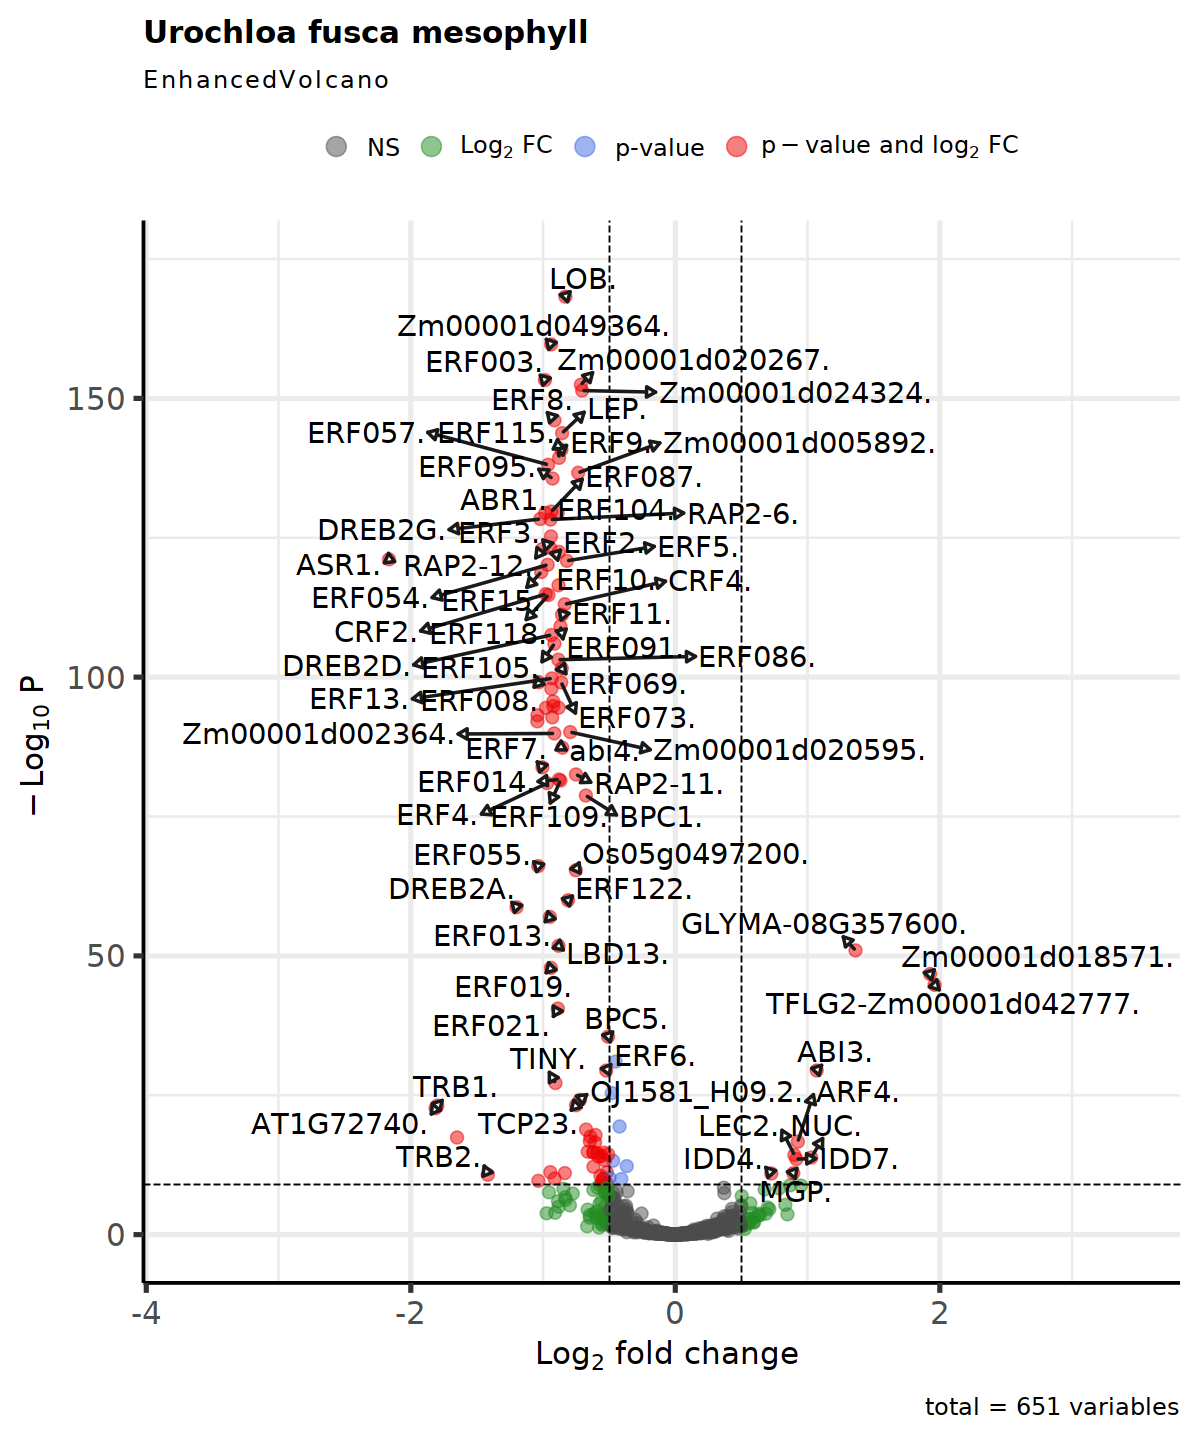

In [25]:
options(repr.plot.width=10, repr.plot.height=12)

EnhancedVolcano(res_meso,
    lab = rownames(res_meso),
    x = 'log2FoldChange',
    y = 'adjusted_pval',
    title = 'Urochloa fusca mesophyll',
    pCutoff = 10e-10,
    FCcutoff = 0.5,
    pointSize = 3.0,
    labSize = 6.0,
    drawConnectors = TRUE,
    widthConnectors = 0.75)